# Manage folders

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [2]:
import os
import shutil
import sys

import glob
import h5py

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np

In [3]:
!mkdir data
shutil.copyfile('drive/MyDrive/shapenet_part_seg_hdf5_data.zip', 'data/shapenet_part_seg_hdf5_data.zip')
!unzip data/shapenet_part_seg_hdf5_data.zip
os.rename('hdf5_data', 'data/hdf5_data')

Archive:  data2/shapenet_part_seg_hdf5_data.zip
   creating: hdf5_data/
  inflating: hdf5_data/ply_data_train5.h5  
  inflating: hdf5_data/catid_partid_to_overallid.json  
  inflating: hdf5_data/part_color_mapping.json  
  inflating: hdf5_data/ply_data_train1.h5  
  inflating: hdf5_data/ply_data_train3.h5  
  inflating: hdf5_data/overallid_to_catid_partid.json  
  inflating: hdf5_data/ply_data_val0.h5  
  inflating: hdf5_data/ply_data_train0.h5  
  inflating: hdf5_data/ply_data_test1.h5  
  inflating: hdf5_data/all_object_categories.txt  
  inflating: hdf5_data/color_partid_catid_map.txt  
  inflating: hdf5_data/ply_data_test0.h5  
  inflating: hdf5_data/test_hdf5_file_list.txt  
 extracting: hdf5_data/val_hdf5_file_list.txt  
  inflating: hdf5_data/ply_data_train4.h5  
  inflating: hdf5_data/ply_data_train2.h5  
  inflating: hdf5_data/train_hdf5_file_list.txt  


# Prepare data

In [4]:
def load_data(partition):
    DATA_DIR = 'data'
    all_data = []
    all_label = []
    all_seg = []
    if partition == 'trainval':
        file = glob.glob(os.path.join(DATA_DIR, 'hdf5_data', '*train*.h5')) \
               + glob.glob(os.path.join(DATA_DIR, 'hdf5_data', '*val*.h5'))
    else:
        file = glob.glob(os.path.join(DATA_DIR, 'hdf5_data', '*%s*.h5'%partition))
    for h5_name in file:
        f = h5py.File(h5_name, 'r+')
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        seg = f['pid'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
        all_seg.append(seg)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    all_seg = np.concatenate(all_seg, axis=0)
    return all_data, all_label, all_seg

data, labels, segs = load_data('trainval')
data.shape

(14007, 2048, 3)

In [5]:
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud


def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud


class ShapeNet(Dataset):
    def __init__(self, num_points, partition='trainval'):
        self.data, self.label, self.seg = load_data(partition)
        self.num_points = num_points
        self.partition = partition        

    def __getitem__(self, item):
        pointcloud = self.data[item][:self.num_points]
        label = self.label[item]
        seg = self.seg[item][:self.num_points]
        if self.partition == 'trainval':
            pointcloud = translate_pointcloud(pointcloud)
            shuffle = np.random.permutation(self.num_points)
            pointcloud = pointcloud[shuffle]
            seg = seg[shuffle]
        pointcloud = np.transpose(pointcloud, axes=(1, 0))
        return pointcloud, label, seg

    def __len__(self):
        return self.data.shape[0]


train = ShapeNet(1024)

In [6]:
train_dloader = torch.utils.data.DataLoader(train,
                                            batch_size=32,
                                            shuffle=True)

# Train

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx


def get_graph_feature(x, k=20):
    batch_size = x.size(0)
    num_points = x.size(2)
    num_dims = x.size(1)
    x = x.reshape(batch_size, -1, num_points)
    idx = knn(x, k=k)

    idx_base = torch.arange(0, batch_size, device=device)
    idx_base = idx_base.reshape(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.reshape(-1)

    x = x.transpose(2, 1)
    feature = x.reshape(batch_size * num_points, -1)[idx, :]
    feature = feature.reshape(batch_size, num_points, k, num_dims) 
    x = x.reshape(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

In [9]:
class DGCNN_partseg(nn.Module):
    def __init__(self, args, seg_num_all):
        super(DGCNN_partseg, self).__init__()
        self.args = args
        self.seg_num_all = seg_num_all
        self.k = args.k
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm1d(args.emb_dims)
        self.bn7 = nn.BatchNorm1d(64)
        self.bn8 = nn.BatchNorm1d(256)
        self.bn9 = nn.BatchNorm1d(256)
        self.bn10 = nn.BatchNorm1d(128)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv6 = nn.Sequential(nn.Conv1d(192, args.emb_dims, kernel_size=1, bias=False),
                                   self.bn6,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv7 = nn.Sequential(nn.Conv1d(16, 64, kernel_size=1, bias=False),
                                   self.bn7,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv8 = nn.Sequential(nn.Conv1d(1280, 256, kernel_size=1, bias=False),
                                   self.bn8,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.dp1 = nn.Dropout(p=args.dropout)
        self.conv9 = nn.Sequential(nn.Conv1d(256, 256, kernel_size=1, bias=False),
                                   self.bn9,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.dp2 = nn.Dropout(p=args.dropout)
        self.conv10 = nn.Sequential(nn.Conv1d(256, 128, kernel_size=1, bias=False),
                                   self.bn10,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv11 = nn.Conv1d(128, self.seg_num_all, kernel_size=1, bias=False)
        

    def forward(self, x, l):
        batch_size = x.size(0)
        num_points = x.size(2)

        x = get_graph_feature(x, k=self.k)      # (batch_size, 3, num_points) -> (batch_size, 3*2, num_points, k)
        x = self.conv1(x)                       # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        x1 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x1, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv3(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x2 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x2, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv5(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x3 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = torch.cat((x1, x2, x3), dim=1)      # (batch_size, 64*3, num_points)

        x = self.conv6(x)                       # (batch_size, 64*3, num_points) -> (batch_size, emb_dims, num_points)
        x = x.max(dim=-1, keepdim=True)[0]      # (batch_size, emb_dims, num_points) -> (batch_size, emb_dims, 1)

        l = l.view(batch_size, -1, 1)           # (batch_size, num_categoties, 1)
        l = self.conv7(l)                       # (batch_size, num_categoties, 1) -> (batch_size, 64, 1)

        x = torch.cat((x, l), dim=1)            # (batch_size, 1088, 1)
        x = x.repeat(1, 1, num_points)          # (batch_size, 1088, num_points)

        x = torch.cat((x, x1, x2, x3), dim=1)   # (batch_size, 1088+64*3, num_points)

        x = self.conv8(x)                       # (batch_size, 1088+64*3, num_points) -> (batch_size, 256, num_points)
        x = self.dp1(x)
        x = self.conv9(x)                       # (batch_size, 256, num_points) -> (batch_size, 256, num_points)
        x = self.dp2(x)
        x = self.conv10(x)                      # (batch_size, 256, num_points) -> (batch_size, 128, num_points)
        x = self.conv11(x)                      # (batch_size, 256, num_points) -> (batch_size, seg_num_all, num_points)
        
        return x

In [10]:
class Args():
    def __init__(self):
        return
args = Args()
args.k = 20
args.emb_dims = 1024
args.dropout = 0.1

In [11]:
model = DGCNN_partseg(args, 50).to(device)
tmp = torch.randn([1, 3, 1024], device=device)
tmp_l = torch.randn([1, 16], device=device)
tmp_seg = torch.tensor(train.__getitem__(0)[2], device=device).unsqueeze(0)
model.eval()
pred = model(tmp, tmp_l)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
loss_list = []

In [13]:

def one_hot_enc(tgt, num_cats):
    res = torch.zeros([tgt.shape[0], num_cats])
    for i in range(tgt.shape[0]):
        res[i, tgt[i][0]] = 1.
    return res

In [151]:

model.train()

for epoch in range(2):
    for i, (x, labels, segs) in enumerate(train_dloader):
        labels = one_hot_enc(labels, 16)

        optimizer.zero_grad()
        pred = model(x.to(device), labels.to(device))
        loss = criterion(pred, segs.to(device))
        loss.backward()
        optimizer.step()

        print('Epoch {} Step {} Loss = {}'.format(epoch, i, loss.detach().item()))
        loss_list.append(loss.detach().item())

Epoch 0 Step 0 Loss = 0.6623663306236267
Epoch 0 Step 1 Loss = 0.4322976768016815
Epoch 0 Step 2 Loss = 0.491150826215744
Epoch 0 Step 3 Loss = 0.5958988666534424
Epoch 0 Step 4 Loss = 0.6488503813743591
Epoch 0 Step 5 Loss = 0.48725655674934387
Epoch 0 Step 6 Loss = 0.4372842311859131
Epoch 0 Step 7 Loss = 0.546358048915863
Epoch 0 Step 8 Loss = 0.4499749541282654
Epoch 0 Step 9 Loss = 0.3978484272956848
Epoch 0 Step 10 Loss = 0.5505785346031189
Epoch 0 Step 11 Loss = 0.4473360776901245
Epoch 0 Step 12 Loss = 0.4402425289154053
Epoch 0 Step 13 Loss = 0.4229482114315033
Epoch 0 Step 14 Loss = 0.5818180441856384
Epoch 0 Step 15 Loss = 0.4185170531272888
Epoch 0 Step 16 Loss = 0.5011383295059204
Epoch 0 Step 17 Loss = 0.5863608717918396
Epoch 0 Step 18 Loss = 0.4724109470844269
Epoch 0 Step 19 Loss = 0.5453420281410217
Epoch 0 Step 20 Loss = 0.5184279680252075
Epoch 0 Step 21 Loss = 0.6696736812591553
Epoch 0 Step 22 Loss = 0.535200297832489
Epoch 0 Step 23 Loss = 0.5421517491340637
Epoc

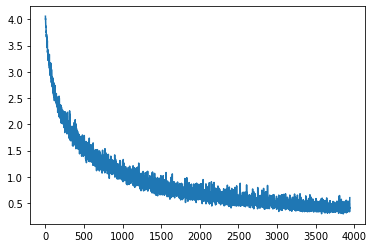

In [152]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_list)), loss_list)

In [153]:
torch.save(model.state_dict(), '3D_net')

In [154]:
model.eval()
print(' ')

# Test

In [155]:
test = ShapeNet(1024, partition='test')

test_dloader = torch.utils.data.DataLoader(test,
                                            batch_size=32,
                                            shuffle=False)

In [475]:
preds = []
segs = []

with torch.no_grad():
    for i, (x, tgt, seg) in enumerate(test_dloader):
        tgt = one_hot_enc(tgt, 16)

        pred = model(x.to(device), tgt.to(device)).detach()
        pred = pred.transpose(1, 2)
        # pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=2)

        preds.append(pred)
        segs.append(seg)

preds = torch.cat(preds)
segs = torch.cat(segs)

In [ ]:
def iou_score(pred_np, seg_np):
    shape_ious = []
    for shape_idx in range(seg_np.shape[0]):

        parts = range(50)
        part_ious = []
        for part in parts:
            I = np.sum(np.logical_and(pred_np[shape_idx] == part, seg_np[shape_idx] == part))
            U = np.sum(np.logical_or(pred_np[shape_idx] == part, seg_np[shape_idx] == part))

            if U != 0:
                iou = I / float(U)
                part_ious.append(iou)
        shape_ious.append(np.mean(part_ious))
    return sum(shape_ious) / seg_np.shape[0]

In [481]:
from sklearn.metrics import accuracy_score as acc

preds = preds.cpu()
print(acc(segs.reshape(-1), preds.reshape(-1)))
print(iou_score(preds.numpy(), segs.numpy()))

0.8815148339639874
0.7059984293333671


# Visualization

In [500]:
import random
ind = random.randint(0, len(test))
cloud, label, seg = test.__getitem__(ind)
cloud.shape

(3, 1024)

In [501]:
with torch.no_grad():
    label = one_hot_enc(torch.tensor(label).unsqueeze(0), 16)

    seg_pred = model(torch.tensor(cloud).unsqueeze(0).to(device),
                    label.to(device)).detach()

    seg_pred = torch.max(seg_pred, dim=1)
    seg_pred = seg_pred[1].cpu().numpy().reshape(-1)

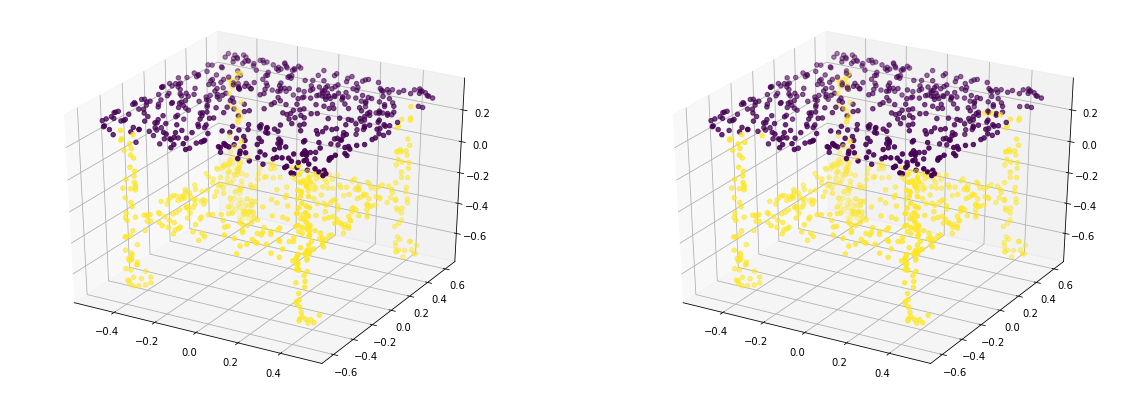

In [502]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(cloud[0], cloud[2], cloud[1], c=seg)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(cloud[0], cloud[2], cloud[1], c=seg_pred)

In [503]:
label = label.argmax().item()
iou_score(seg_pred.reshape(1, -1), seg.reshape(1, -1))

0.9748957169459962

In [504]:
acc(seg, seg_pred)

0.9873046875